In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from influxdb import DataFrameClient
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, make_scorer, classification_report
from sklearn2pmml import make_pmml_pipeline, sklearn2pmml
import requests

/Users/Marius/Programs/Classification/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import warnings
import urllib3
# supress warning caused by self-generated ssl certificate
warnings.filterwarnings('ignore', category=urllib3.exceptions.InsecureRequestWarning)

# FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Get data from influxDB

In [3]:
client = DataFrameClient(host='193.196.37.63', port=8086, ssl=True)

In [4]:
client.get_list_database()

[{'name': '_internal'}, {'name': 'production'}, {'name': 'test'}]

In [5]:
client.switch_database('production')

In [6]:
result = client.query('SELECT * FROM sensor')
#result_acceleration = client.query('SELECT * FROM acceleration')['acceleration']
#sensor_data = pd.concat([result_orientation, result_acceleration], sort=False).sort_index() # sort by date after concatenation
# sensor_data = pd.merge(result_orientation, result_acceleration, how='outer', left_on=result_orientation.index, right_on=result_acceleration.index)
sensor_data=result['sensor']


# Data Understanding

In [164]:
print(sensor_data.shape)
sensor_data.head()

(16205, 8)


,acceleration_x,acceleration_y,acceleration_z,label,orientation_alpha,orientation_beta,orientation_gamma,subject
2019-08-08 17:37:32.269000+00:00,37,-53,140,running,232517,-12140,4009,Marius1
2019-08-08 17:37:32.309000+00:00,-196,163,303,running,356322,-41042,3101,Marius1
2019-08-08 17:37:32.359000+00:00,280,-174,439,running,357088,-41237,3012,Marius1
2019-08-08 17:37:32.409000+00:00,1989,224,706,running,239429,-41780,3172,Marius1
2019-08-08 17:37:32.459000+00:00,2292,-94,597,running,3395,-42328,2622,Marius1


In [8]:
# sensor_data.to_csv('backup')

In [165]:
sensor_data.describe()

,acceleration_x,acceleration_y,acceleration_z,orientation_alpha,orientation_beta,orientation_gamma
count,16205.000000,16205.000000,16205.000000,16205.000000,16205.000000,16205.000000
mean,-67.652761,801.489293,515.948596,119806.704782,-72708.111139,9301.125949
std,3968.056506,2708.478698,1251.907821,97673.288915,9870.381621,36917.785756
min,-19033.000000,-15931.000000,-8621.000000,239.000000,-107956.000000,-89294.000000
25%,-1192.000000,-270.000000,-136.000000,41251.000000,-80429.000000,-23140.000000
50%,-42.000000,112.000000,312.000000,101700.000000,-75555.000000,3907.000000
75%,1045.000000,1322.000000,1165.000000,146962.000000,-66137.000000,44497.000000
max,21365.000000,21587.000000,9945.000000,359964.000000,-12140.000000,89696.000000


In [166]:
sns.set(rc={'figure.figsize':(15, 5)})

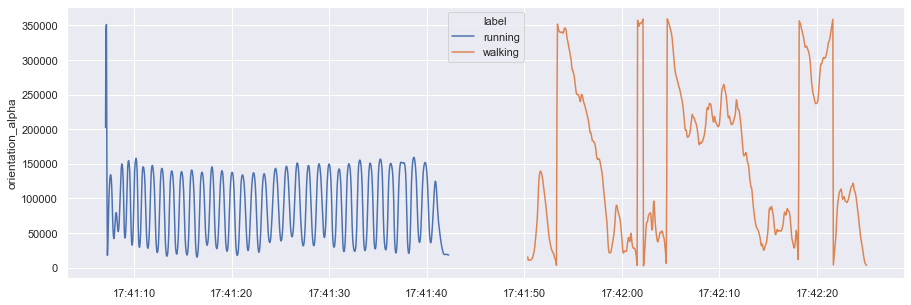

In [167]:
sns.lineplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='orientation_alpha', hue='label', data=sensor_data[sensor_data['subject']=='Marius2'])
plt.show()

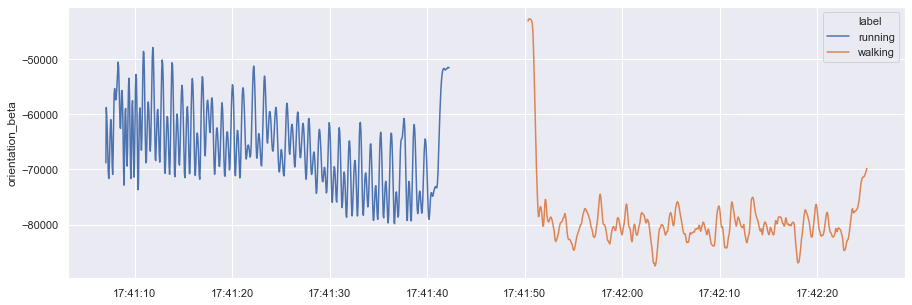

In [168]:
sns.lineplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='orientation_beta', hue='label', data=sensor_data[sensor_data['subject']=='Marius2'])
plt.show()

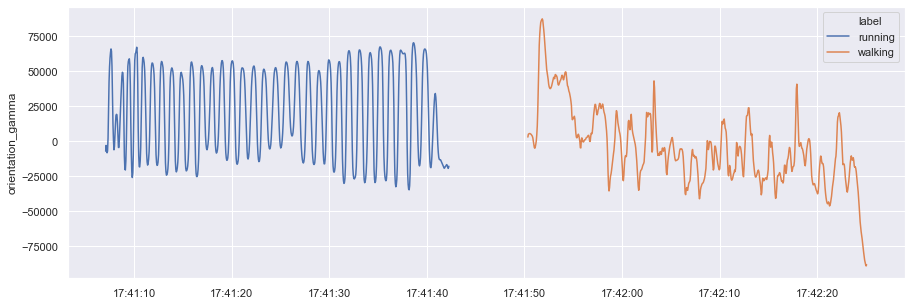

In [169]:
sns.lineplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='orientation_gamma', hue='label', data=sensor_data[sensor_data['subject']=='Marius2'])
plt.show()

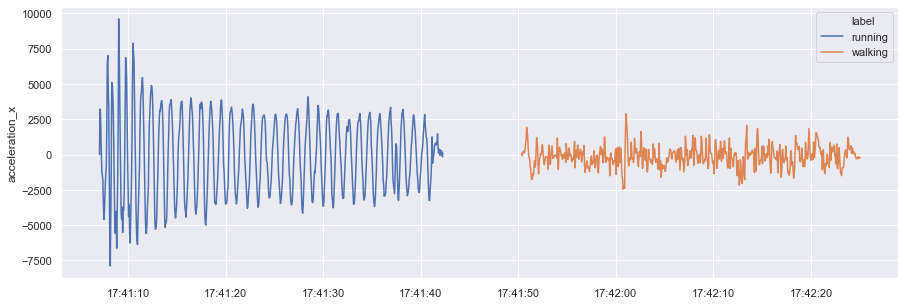

In [170]:
sns.lineplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='acceleration_x', hue='label', data=sensor_data[sensor_data['subject']=='Marius2'])
plt.show()

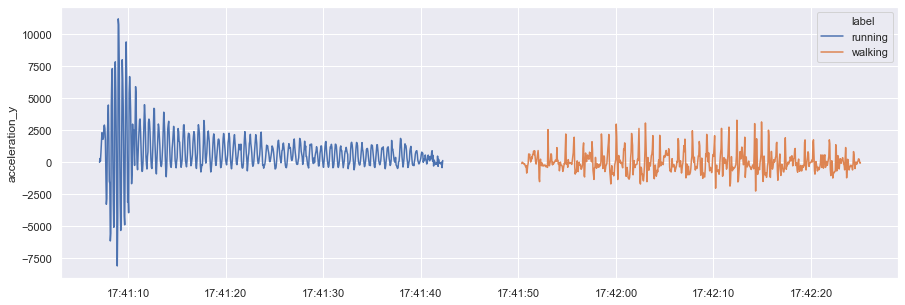

In [171]:
sns.lineplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='acceleration_y', hue='label', data=sensor_data[sensor_data['subject']=='Marius2'])
plt.show()


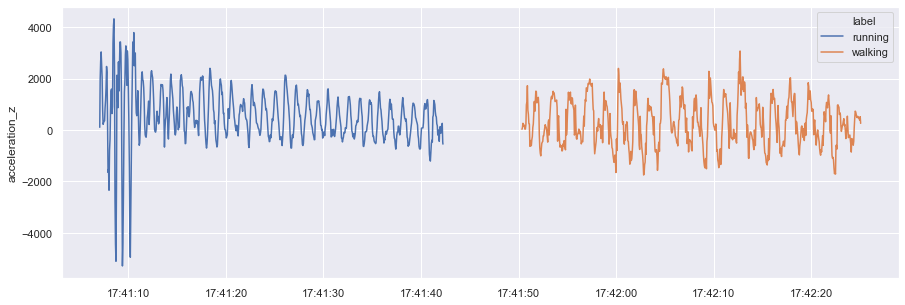

In [172]:
sns.lineplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='acceleration_z', hue='label', data=sensor_data[sensor_data['subject']=='Marius2'])
plt.show()


# Feature Engineering

In [173]:
sensor_data.head()

,acceleration_x,acceleration_y,acceleration_z,label,orientation_alpha,orientation_beta,orientation_gamma,subject
2019-08-08 17:37:32.269000+00:00,37,-53,140,running,232517,-12140,4009,Marius1
2019-08-08 17:37:32.309000+00:00,-196,163,303,running,356322,-41042,3101,Marius1
2019-08-08 17:37:32.359000+00:00,280,-174,439,running,357088,-41237,3012,Marius1
2019-08-08 17:37:32.409000+00:00,1989,224,706,running,239429,-41780,3172,Marius1
2019-08-08 17:37:32.459000+00:00,2292,-94,597,running,3395,-42328,2622,Marius1


In [174]:
sensor_data['acceleration_x_rolling_max'] = sensor_data['acceleration_x'].rolling(20).max()
sensor_data['acceleration_x_rolling_min'] = sensor_data['acceleration_x'].rolling(20).min()
sensor_data['acceleration_x_rolling_mean'] = sensor_data['acceleration_x'].rolling(20).mean()

sensor_data.iloc[25:35,:]

,acceleration_x,acceleration_y,acceleration_z,label,orientation_alpha,orientation_beta,orientation_gamma,subject,acceleration_x_rolling_max,acceleration_x_rolling_min,acceleration_x_rolling_mean
2019-08-08 17:37:33.526000+00:00,-2454,9131,-4091,running,154861,-52636,64293,Marius1,8091.0,-13542.0,-415.15
2019-08-08 17:37:33.575000+00:00,-5025,4224,-2635,running,156758,-50811,65178,Marius1,8091.0,-13542.0,-767.15
2019-08-08 17:37:33.627000+00:00,-6013,746,589,running,155507,-53999,66760,Marius1,8091.0,-13542.0,-1139.75
2019-08-08 17:37:33.678000+00:00,-5083,-5022,1945,running,152557,-61239,68958,Marius1,8091.0,-13542.0,-1360.85
2019-08-08 17:37:33.728000+00:00,-3323,-9540,-721,running,146507,-69288,66563,Marius1,8091.0,-13542.0,-1508.70
2019-08-08 17:37:33.779000+00:00,-3501,-1300,-91,running,121497,-76718,43657,Marius1,8091.0,-13542.0,-1729.40
2019-08-08 17:37:33.829000+00:00,-52,8596,1477,running,77492,-77693,6606,Marius1,8091.0,-13542.0,-1620.85
2019-08-08 17:37:33.880000+00:00,8502,10251,1442,running,52912,-73762,-9060,Marius1,8502.0,-13542.0,-799.20
2019-08-08 17:37:33.931000+00:00,7186,4428,3887,running,53865,-71989,-7490,Marius1,8502.0,-12012.0,237.20
2019-08-08 17:37:33.982000+00:00,2967,-1156,4500,running,70859,-73172,5269,Marius1,8502.0,-6013.0,986.15


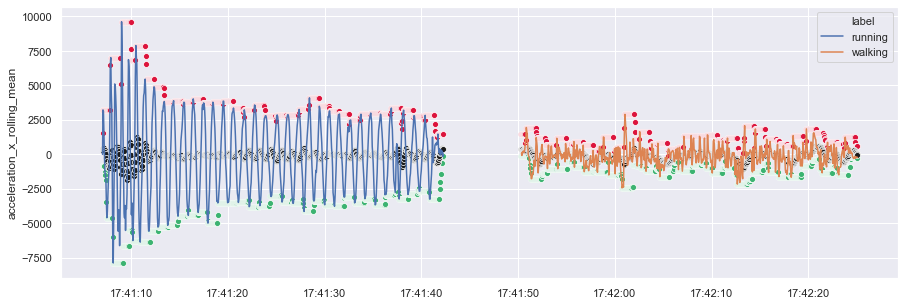

In [175]:
sns.lineplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='acceleration_x', hue='label', data=sensor_data[sensor_data['subject']=='Marius2'])
sns.scatterplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='acceleration_x_rolling_max', data=sensor_data[sensor_data['subject']=='Marius2'], color='crimson')
sns.scatterplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='acceleration_x_rolling_min', data=sensor_data[sensor_data['subject']=='Marius2'], color='mediumseagreen')
sns.scatterplot(x=np.asarray(sensor_data[sensor_data['subject']=='Marius2'].index,dtype='datetime64[ns]'), y='acceleration_x_rolling_mean', data=sensor_data[sensor_data['subject']=='Marius2'], color='k')

plt.show()

In [176]:
# min and max seem particularily promising.
# let's do it for all features: 

# get original data again
result = client.query('SELECT * FROM sensor')
sensor_data=result['sensor']

for col in sensor_data.columns.drop(['label', 'subject', 'acceleration_x']):
    sensor_data[(col + '_rolling_max')] = sensor_data[col].rolling(20).max()
    sensor_data[(col + '_rolling_min')] = sensor_data[col].rolling(20).min()
    sensor_data[(col + '_rolling_mean')] = sensor_data[col].rolling(20).mean()

In [177]:
sensor_data.columns

Index(['acceleration_x', 'acceleration_y', 'acceleration_z', 'label',
       'orientation_alpha', 'orientation_beta', 'orientation_gamma', 'subject',
       'acceleration_y_rolling_max', 'acceleration_y_rolling_min',
       'acceleration_y_rolling_mean', 'acceleration_z_rolling_max',
       'acceleration_z_rolling_min', 'acceleration_z_rolling_mean',
       'orientation_alpha_rolling_max', 'orientation_alpha_rolling_min',
       'orientation_alpha_rolling_mean', 'orientation_beta_rolling_max',
       'orientation_beta_rolling_min', 'orientation_beta_rolling_mean',
       'orientation_gamma_rolling_max', 'orientation_gamma_rolling_min',
       'orientation_gamma_rolling_mean'],
      dtype='object')

In [178]:
# drop the first and last 20 rows containing null values
print(sensor_data.shape)
sensor_data = sensor_data.dropna()
print(sensor_data.shape)

(16205, 23)
(16186, 23)


In [179]:
sensor_data_X = sensor_data.drop(columns=['label'])
sensor_data_y = sensor_data[['label']]

### PCA

In [180]:
# transforming 3 features into 3 PCs ??
pca = PCA(n_components=3)
pca.fit(sensor_data_X.drop(columns=['subject']))
pca.explained_variance_ratio_

array([0.60144601, 0.19312342, 0.10491951])

In [181]:
sensor_data_X_transformed = pd.DataFrame(pca.transform(sensor_data_X.drop(columns='subject')))


In [182]:
# merge subject back on (assuming PCA feature vectors are in same order)
sensor_data_X_transformed = pd.merge(sensor_data_X_transformed, sensor_data_X[['subject']].reset_index().drop('index', axis=1), left_on=sensor_data_X_transformed.index, right_on=sensor_data_X[['subject']].reset_index().drop('index', axis=1).index).drop('key_0', axis=1)
print(sensor_data_X_transformed.shape)
sensor_data_X_transformed.head()

(16186, 4)


,0,1,2,subject
0,27162.764500,-160274.600627,-52928.303090,Marius1
1,24836.784996,-158297.022267,-47096.687529,Marius1
2,27480.395685,-153648.547690,-28365.420193,Marius1
3,-36737.794525,-60237.399778,11257.824123,Marius1
4,-72660.973899,18749.217547,56962.401994,Marius1


# Model Selection & Training

### Leave-one-subject-out Cross Validation



In [183]:
# an iterable yielding (train, test) splits as arrays of indices.
# cv_subject_indices = [(sensor_data_X[sensor_data_X['subject'] != subject].index, sensor_data_X[sensor_data_X['subject'] == subject].index) for subject in sensor_data.subject.unique()]


In [184]:
# this is actually a leave-one-subject-out implementation
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
logo = LeaveOneGroupOut()
cv_subject_indices = [(train_index, test_index) for train_index, test_index in logo.split(X=sensor_data_X_transformed, y=sensor_data_y, groups=sensor_data_X_transformed['subject'])]


In [185]:
from sklearn.model_selection import cross_validate
clf = SVC(gamma='auto')
cv_results = cross_validate(estimator=clf, X=sensor_data_X_transformed.drop(columns=['subject']), y=sensor_data_y.values.ravel(), cv=cv_subject_indices, n_jobs=-1)


In [186]:
cv_results

{'fit_time': array([17.63546801, 17.73632789, 19.85815597, 18.81107497, 19.16643214,
        18.25513411, 19.44653797, 19.82028389,  9.89888787, 10.44083285]),
 'score_time': array([0.4347353 , 0.59085202, 0.27834082, 0.49526191, 0.47863889,
        0.52517796, 0.20636201, 0.30446315, 0.23880506, 0.22324133]),
 'test_score': array([0.58039492, 0.56380275, 0.49638205, 0.57179487, 0.55880561,
        0.56724512, 0.45851852, 0.5455192 , 0.53374233, 0.50136986])}

In [187]:
# same amount of test scores as subjects - makes sense :)
len(sensor_data_X_transformed.subject.unique()) == len(cv_results['test_score'])

True

test scores indicate a quite random classification (class rations should be about 50/50)

In [188]:
# let's do a quick grid search on subset (5000 instances) with 3-fold CV
parameters = {'C':[1, 10, 100], 'gamma':['auto', 'scale']}
svc = SVC(random_state=1)
clf = GridSearchCV(svc, parameters, cv=3, n_jobs=-1, verbose=10)
clf.fit(X=sensor_data_X_transformed.iloc[:5000,].drop(columns=['subject']), y=sensor_data_y.iloc[:5000,].values.ravel())
pd.DataFrame(clf.cv_results_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    0.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.373775,0.011985,0.118692,0.004801,1,auto,"{'C': 1, 'gamma': 'auto'}",0.519784,0.519808,0.519808,0.5198,0.000011,4
1,0.135716,0.019064,0.055688,0.001265,1,scale,"{'C': 1, 'gamma': 'scale'}",0.890288,0.876951,0.895558,0.8876,0.007829,3
2,0.648763,0.005300,0.097025,0.019074,10,auto,"{'C': 10, 'gamma': 'auto'}",0.519784,0.519808,0.519808,0.5198,0.000011,4
3,0.129521,0.005761,0.044236,0.001289,10,scale,"{'C': 10, 'gamma': 'scale'}",0.904676,0.862545,0.902161,0.8898,0.019294,2
4,0.519672,0.012921,0.058832,0.000178,100,auto,"{'C': 100, 'gamma': 'auto'}",0.519784,0.519808,0.519808,0.5198,0.000011,4
5,0.160661,0.008002,0.032820,0.002994,100,scale,"{'C': 100, 'gamma': 'scale'}",0.892686,0.875150,0.908163,0.8920,0.013484,1


looks much better: apparently gamma='scale' instead of 'auto' was the determining factor

In [189]:
clf.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

### Leave-one-out Cross Validation

In [190]:
# On a subset of data
loo = LeaveOneOut()
cv_subject_indices = [(train_index, test_index) for train_index, test_index in loo.split(X=sensor_data_X_transformed.iloc[:5000,], y=sensor_data_y.iloc[:5000,], groups=sensor_data_X.iloc[:5000,]['subject'])]
# best params from grid search
clf = SVC(gamma='scale', C=100)
cv_results = cross_validate(estimator=clf, X=sensor_data_X_transformed.iloc[:5000,].drop(columns=['subject']), y=sensor_data_y.iloc[:5000,].values.ravel(), cv=cv_subject_indices, n_jobs=-1, verbose=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  6.3min finished


In [191]:
cv_results['test_score'].mean()

0.9378

### Recursive Feature Elimination (with Cross Validation)

In [192]:
# https://scikit-learn.org/stable/modules/feature_selection.html
from sklearn.feature_selection import RFECV
# Weights assigned to the features only available in the case of the linear kernel
clf = SVC(C=100, gamma='scale', kernel='linear')
rfecv = RFECV(clf, step=1, cv=3, n_jobs=-1)

In [193]:
# only use subset (linear kernel takes forever)
# check if labels of first 1000 are about equally distributed
sensor_data_y.iloc[:1000,].describe()

,label
count,1000
unique,2
top,running
freq,595


In [194]:
# use all features (not PCs)
rfecv.fit(X=sensor_data_X.iloc[:1000,].drop(columns=['subject']), y=sensor_data_y.iloc[:1000,].values.ravel())

rfecv.grid_scores_

array([0.98103792, 0.98103792, 0.98103792, 0.97803492, 0.97104889,
       0.96007085, 0.95608782, 0.95608782, 0.95608782, 0.95608782,
       0.95608782, 0.95608782, 0.95608782, 0.95608782, 0.95608782,
       0.95608782, 0.95608782, 0.95608782, 0.95608782, 0.95608782,
       0.95608782])

In [195]:
pd.DataFrame(dict(feature = pd.Series(sensor_data_X.iloc[:1000,].drop(columns=['subject']).columns), rank = pd.Series(rfecv.ranking_))).sort_values('rank')
             

,feature,rank
6,acceleration_y_rolling_max,1
7,acceleration_y_rolling_min,2
4,orientation_beta,3
15,orientation_beta_rolling_max,4
18,orientation_gamma_rolling_max,5
10,acceleration_z_rolling_min,6
9,acceleration_z_rolling_max,7
16,orientation_beta_rolling_min,8
13,orientation_alpha_rolling_min,9
2,acceleration_z,10


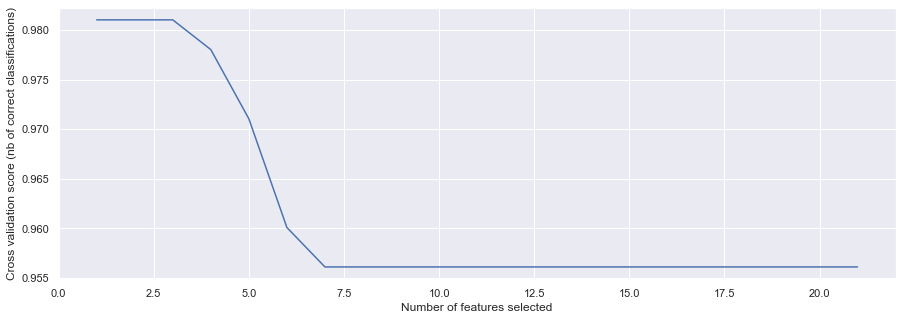

In [196]:
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Model Training & Evaluation

Do proper test-train split (20% holdout) and perform classic 10 fold CV with params from GS (ignoring the subjects)

In [199]:
from sklearn.model_selection import train_test_split
sensor_data_X_transformed_train, sensor_data_X_transformed_test, sensor_data_y_train, sensor_data_y_test = train_test_split(sensor_data_X_transformed.drop(columns=['subject']), sensor_data_y.values.ravel(), test_size=0.2, random_state=42)

clf = SVC(C=100, gamma='scale')
clf.fit(sensor_data_X_transformed_train, sensor_data_y_train)

print(classification_report(clf.predict(sensor_data_X_transformed_test), sensor_data_y_test))


              precision    recall  f1-score   support

     running       0.92      0.85      0.88      1606
     walking       0.86      0.92      0.89      1632

    accuracy                           0.89      3238
   macro avg       0.89      0.89      0.89      3238
weighted avg       0.89      0.89      0.89      3238



In [200]:
# Let's try it with 'original' features (no PCA)
sensor_data_X_train, sensor_data_X_test, sensor_data_y_train, sensor_data_y_test = train_test_split(sensor_data_X.drop(columns=['subject']), sensor_data_y.values.ravel(), test_size=0.2, random_state=42)

clf = SVC(C=100, gamma='scale')
clf.fit(sensor_data_X_train, sensor_data_y_train)

print(classification_report(clf.predict(sensor_data_X_test), sensor_data_y_test))


              precision    recall  f1-score   support

     running       0.99      0.99      0.99      1484
     walking       0.99      0.99      0.99      1754

    accuracy                           0.99      3238
   macro avg       0.99      0.99      0.99      3238
weighted avg       0.99      0.99      0.99      3238



In [203]:
# Let's try it with two highest ranked features
sensor_data_X_train, sensor_data_X_test, sensor_data_y_train, sensor_data_y_test = train_test_split(sensor_data_X[['acceleration_y_rolling_max', 'acceleration_y_rolling_min']], sensor_data_y.values.ravel(), test_size=0.2, random_state=42)

clf = SVC(C=100, gamma='scale')
clf.fit(sensor_data_X_train, sensor_data_y_train)

print(classification_report(clf.predict(sensor_data_X_test), sensor_data_y_test))




              precision    recall  f1-score   support

     running       0.92      0.95      0.94      1435
     walking       0.96      0.93      0.95      1803

    accuracy                           0.94      3238
   macro avg       0.94      0.94      0.94      3238
weighted avg       0.94      0.94      0.94      3238



# Deployment

In [211]:
from sklearn2pmml.pipeline import PMMLPipeline

pipeline = PMMLPipeline([
    ("classifier", SVC(C=100, gamma='scale'))
])
pipeline.fit(sensor_data_X_train, sensor_data_y_train)
print(classification_report(pipeline.predict(sensor_data_X_test), sensor_data_y_test))



              precision    recall  f1-score   support

     running       0.92      0.95      0.94      1435
     walking       0.96      0.93      0.95      1803

    accuracy                           0.94      3238
   macro avg       0.94      0.94      0.94      3238
weighted avg       0.94      0.94      0.94      3238



In [212]:
sklearn2pmml(pipeline, 'SupportVectorMachine.pmml', with_repr=True)

The pmml file is now (via ssh) uploaded to the machine and then loaded into the running openscoring server (it needs to be uploaded first to work around hhtp cross origin settings that would be needed when making the request from another machine)
> curl --insecure -X PUT --data-binary @SupportVectorMachine.pmml -H "Content-type: text/xml" https://localhost:8080/openscoring/model/SupportVectorMachine


In [233]:
# Test the REST endpoint (the endpoint is actually called by the JS of the WebApp)
url = 'https://193.196.37.63:8080/openscoring/model/SupportVectorMachine'
data = {
  "id": "record--01", 
  "arguments": {
      "acceleration_y_rolling_max": 15442.0,
      "acceleration_y_rolling_min": -11489.0
  }
}

response = requests.post(url, json=data, verify=False)  # ignore missing SSL certificate
response.json()

{'id': 'record--01', 'results': {'y': 'running'}}

In [234]:
sensor_data.iloc[100:101]

,acceleration_x,acceleration_y,acceleration_z,label,orientation_alpha,orientation_beta,orientation_gamma,subject,acceleration_y_rolling_max,acceleration_y_rolling_min,...,acceleration_z_rolling_mean,orientation_alpha_rolling_max,orientation_alpha_rolling_min,orientation_alpha_rolling_mean,orientation_beta_rolling_max,orientation_beta_rolling_min,orientation_beta_rolling_mean,orientation_gamma_rolling_max,orientation_gamma_rolling_min,orientation_gamma_rolling_mean
2019-08-08 17:37:38.290000+00:00,1384,15442,279,running,139699,-52158,63022,Marius1,15442.0,-11489.0,...,1118.45,149615.0,38605.0,99374.45,-52158.0,-75009.0,-65081.45,67912.0,-15209.0,31915.55


In [ ]:
# TODO DELETE
# check whether local clf predicts the same as the endpoint returns
for i in len(X_test):
    print(i)
    print('Lokal: ', pl.predict(X_test.iloc[i:i+1]))
    
    data = {
        "id": "record--01", 
        "arguments": {
            "x1": int(X_test.iloc[i])
        }
    }

    response = requests.post(url, json=data)
    print('Server:', response.json()['result']['y'])